In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


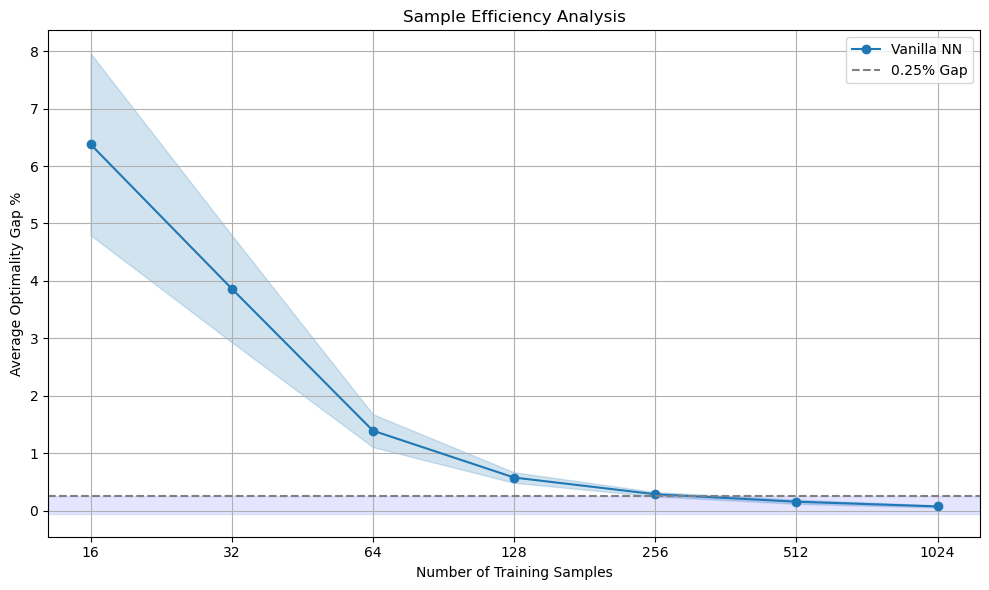

In [22]:
# Create vanilla results dataframe from the provided data
optimal_loss = []
for lead_time in [3, 4]:
    for underage_cost in [9, 19]:
        # Find matching row in provided data
        row = {
            'store_lead_time': lead_time,
            'store_underage_cost': underage_cost,
            'Architecture Class': 'Optimal Loss',
            'Test Loss': None
        }
        if lead_time == 3 and underage_cost == 9:
            row['Test Loss'] = 6.53
        elif lead_time == 3 and underage_cost == 19:
            row['Test Loss'] = 8.36
        elif lead_time == 4 and underage_cost == 9:
            row['Test Loss'] = 6.84
        elif lead_time == 4 and underage_cost == 19:
            row['Test Loss'] = 8.89
        optimal_loss.append(row)
echelon_df = pd.DataFrame(optimal_loss)
dfs = [echelon_df]

# Define color scheme for architectures
color_scheme = {
    "Vanilla NN": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "Vanilla NN": "-",  # Solid
}

testset_name = "finals_one_store_sample_efficiency"

# Define paths for each architecture
architectures = {
    "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_one_store'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
params = {
    'store_lead_time': [3, 4],
    'store_underage_cost': [9, 19]
}

# Define sample sizes from 16 to 1024
sample_sizes = [16, 32, 64, 128, 256, 512, 1024]

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            for sample_size in sample_sizes:
                df = results_interpretor.make_table({1: path},
                    {'store_lead_time': lead_time,
                     'store_underage_cost': underage_cost,
                     'train_dev_sample_and_batch_size': [sample_size],
                     'samples': list(range(1, 11))},  # Add samples 1-10
                    default_condition_setter, custom_data_filler,
                    sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
                    test_loss_limit = 1000)
                if df.empty:
                    continue
                
                df.insert(2, 'Architecture Class', arch_name)
                df.insert(1, 'hyperparam_name', arch_name)
                df['store_lead_time'] = lead_time
                df['store_underage_cost'] = underage_cost
                df['train_dev_sample_and_batch_size'] = sample_size
                dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate optimality gap percentage using optimal loss values but exclude optimal loss from plotting
optimal_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Optimality Gap %'] = ((df['Test Loss'] - optimal_test_loss) / optimal_test_loss) * 100

# Calculate mean and confidence intervals for each sample size
stats_by_sample = []
for sample_size in sample_sizes:
    sample_data = df[df['train_dev_sample_and_batch_size'] == sample_size]
    if not sample_data.empty:
        gaps = sample_data['Optimality Gap %'].to_numpy()  # Convert to numpy array
        mean_gap = np.mean(gaps)
        std_gap = np.std(gaps)
        ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))  # 95% confidence interval
        stats_by_sample.append({
            'sample_size': sample_size,
            'mean_gap': mean_gap,
            'ci_lower': mean_gap - ci_95,
            'ci_upper': mean_gap + ci_95
        })

stats_df = pd.DataFrame(stats_by_sample)

# Create the plot
plt.figure(figsize=(10, 6))

for arch in df['Architecture Class'].unique():
    if arch != 'Optimal Loss':
        plt.plot(range(len(sample_sizes)), stats_df['mean_gap'].to_numpy(),  # Convert to numpy arrays
                marker='o',
                label=arch,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch])
        
        plt.fill_between(range(len(sample_sizes)),
                        stats_df['ci_lower'].to_numpy(),  # Convert to numpy array
                        stats_df['ci_upper'].to_numpy(),  # Convert to numpy array
                        color=color_scheme[arch],
                        alpha=0.2)

plt.axhspan(-0.05, 0.25, color='blue', alpha=0.1)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.xticks(range(len(sample_sizes)), sample_sizes)
plt.xlabel('Number of Training Samples')
plt.ylabel('Average Optimality Gap %')
plt.title('Sample Efficiency Analysis')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

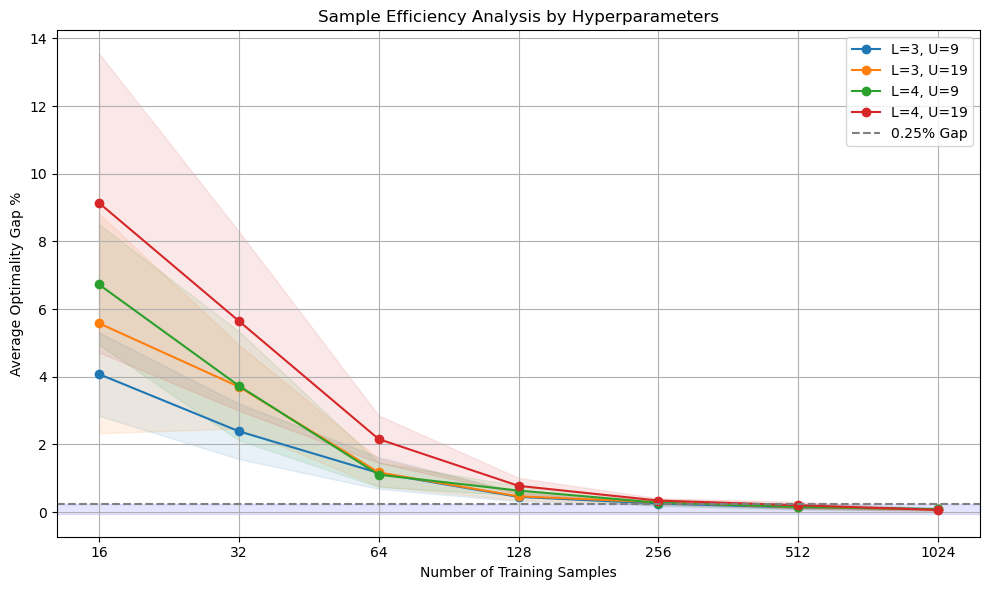

In [24]:
# Calculate optimality gap percentage using optimal loss values but exclude optimal loss from plotting
optimal_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Optimality Gap %'] = ((df['Test Loss'] - optimal_test_loss) / optimal_test_loss) * 100

# Calculate mean and confidence intervals for each sample size and hyperparameter combination
stats_by_sample_and_params = []
for sample_size in sample_sizes:
    for lead_time in df['store_lead_time'].unique():
        for underage_cost in df['store_underage_cost'].unique():
            sample_data = df[
                (df['train_dev_sample_and_batch_size'] == sample_size) &
                (df['store_lead_time'] == lead_time) &
                (df['store_underage_cost'] == underage_cost)
            ]
            if not sample_data.empty:
                gaps = sample_data['Optimality Gap %'].to_numpy()
                mean_gap = np.mean(gaps)
                std_gap = np.std(gaps)
                ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
                stats_by_sample_and_params.append({
                    'sample_size': sample_size,
                    'lead_time': lead_time,
                    'underage_cost': underage_cost,
                    'mean_gap': mean_gap,
                    'ci_lower': mean_gap - ci_95,
                    'ci_upper': mean_gap + ci_95
                })

stats_df = pd.DataFrame(stats_by_sample_and_params)

# Create the plot
plt.figure(figsize=(10, 6))

# Define colors for each parameter combination
colors = {
    (3, 9): '#1f77b4',   # blue
    (3, 19): '#ff7f0e',  # orange  
    (4, 9): '#2ca02c',   # green
    (4, 19): '#d62728'   # red
}

for lead_time in df['store_lead_time'].unique():
    for underage_cost in df['store_underage_cost'].unique():
        param_stats = stats_df[
            (stats_df['lead_time'] == lead_time) &
            (stats_df['underage_cost'] == underage_cost)
        ].sort_values('sample_size')
        
        color = colors[(lead_time, underage_cost)]
        label = f'L={lead_time}, U={underage_cost}'
        plt.plot(range(len(sample_sizes)), param_stats['mean_gap'].to_numpy(),
                marker='o',
                label=label,
                color=color)
        
        plt.fill_between(range(len(sample_sizes)),
                        param_stats['ci_lower'].to_numpy(),
                        param_stats['ci_upper'].to_numpy(),
                        color=color,
                        alpha=0.1)

plt.axhspan(-0.05, 0.25, color='blue', alpha=0.1)
plt.axhline(y=0.25, color='gray', linestyle='--', alpha=1.0, label='0.25% Gap')

plt.xticks(range(len(sample_sizes)), sample_sizes)
plt.xlabel('Number of Training Samples')
plt.ylabel('Average Optimality Gap %')
plt.title('Sample Efficiency Analysis by Hyperparameters')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()